In [1]:
import pandas as pd 
import numpy as np

import tensorflow as tf
import os

from tensorflow.keras.preprocessing.text import Tokenizer   
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

### Loading and Cleaning

In [2]:
la = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Los%20Angeles_restaurant.csv")
sd = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Diego_restaurant.csv")
sf = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Francisco_restaurant.csv")
oc = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Orange%20County_restaurant.csv")

In [29]:
def clean_name(col):
    if 'http' in col:
        col = col.split('Reviews')[1]
        col = col.split('-')[-2]
        col = col.replace('_',' ')
        return col
    else:
        return col

### For visualizing trainning loss and validation loss
import matplotlib.pyplot as plt 
def plot_loss(history):
  hist = pd.DataFrame(history.history)
  plt.plot(hist['mae'], label='training_mae')
  plt.plot(hist['val_mae'], label = 'validation_mae')
  plt.legend()
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.show()

In [4]:
df = pd.concat([la,sd,oc,sf])
df['rating'] = df['rating']/10 
df['restaurant'] = df['restaurant'].apply(lambda x: clean_name(x))
df['restaurant'] = df['restaurant'].apply(lambda x: 'In-N-Out Burger' if 'In N Out' in x else x)
df = df[pd.to_numeric(df['review'], errors='coerce').isnull()]
df = df.dropna(subset=['rating','review'])

## Splitting Train Test Dev

In [5]:
def train_dev_test_df(df, splits):
    """"
    Takes in a dataframe and splits into train dev and test
    """
    np.random.seed(42)
    shuffle_df = df.sample(frac=1)

    train, dev = splits

    X = shuffle_df['review'].to_numpy()
    y = shuffle_df['rating'].to_numpy()

    train_cutoff = int(X.shape[0]*train)
    dev_cutoff = int(X.shape[0]*(train+dev))

    X_train = X[:train_cutoff]
    y_train = y[:train_cutoff]

    X_dev = X[train_cutoff:dev_cutoff]
    y_dev = y[train_cutoff:dev_cutoff]

    X_test = X[dev_cutoff:]
    y_test = y[dev_cutoff:]

    y_train = tf.constant(y_train, dtype=tf.int16)
    y_dev = tf.constant(y_dev, dtype = tf.int16)
    y_test = tf.constant(y_test, dtype=tf.int16)

    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [6]:
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_df(df,(.7,.15))

### Training model with no pretrained Embeddings

In [7]:
vocab_size = 20000
embedding_dim = 100
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index_token = tokenizer.word_index

X_train_token = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_dev_token = tokenizer.texts_to_sequences(X_dev)
X_dev_padded = pad_sequences(X_dev_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
X_train_padded = tf.cast(X_train_padded, dtype=tf.int16)
X_dev_padded = tf.cast(X_dev_padded, dtype=tf.int16)

In [10]:
callback = tf.keras.callbacks.TensorBoard(log_dir='callbacks', histogram_freq=1)

In [12]:


tf.random.set_seed(42)
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(10,activation='relu'),
    Dense(1,activation='relu')
])

model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam() ,metrics=['mae'])

model.fit(X_train_padded, y_train, batch_size=128, epochs=30, validation_data=(X_dev_padded, y_dev), callbacks=callback)

In [ ]:
model.evaluate(X_dev_padded, y_dev)

254/254 [==============================] - 4s 14ms/step - loss: 0.5397 - mae: 0.5397


[0.5397411584854126, 0.5397411584854126]

In [ ]:
model.summary()

### Model Using Pretrained Glove Embeddingings

In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-06-25 22:39:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-25 22:39:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-25 22:39:16--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [13]:
## Vectorizing the training examples
## Chaning the dtype of the samples and labels for faster processing

X_train_vector = tf.cast(vectorizer(X_train), tf.int16)
X_dev_vector = tf.cast(vectorizer(X_dev), tf.int16)

#### Importing embeddings and making matrix

In [14]:
def import_embeddings(path):
    """
    Loads embeddings from a text file
    """
    import os 
    path_to_glove_file = os.path.join(
      os.path.expanduser("~"), path
    )

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    return embeddings_index



def make_embedding_matrix(word_index, embedding_dim, embeddings_index):
    """
    Returns embedding matrix
    """
    num_tokens = len(word_index) + 2
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix
    


In [24]:
def make_model(embedding_matrix, lstm_layer_units, dropout_rate, dense_units, lr=0.001, l2=False):
  """ 
  Returns compiled model with spcified number of hyper paramters
  """

  tf.random.set_seed(42)

  num_tokens, embedding_dim = embedding_matrix.shape

  model = tf.keras.Sequential()
  embedding_layer = Embedding(
      num_tokens,
      embedding_dim,
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
      trainable=False)
  
  model.add(embedding_layer)

  for units in lstm_layer_units[:-1]:
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(Dropout(dropout_rate))
  

  model.add(Bidirectional(LSTM(lstm_layer_units[-1])))
  model.add(Dropout(dropout_rate))

  if isinstance(dense_units,int) and l2 == False:
    model.add(Dense(dense_units,activation='relu'))
  elif isinstance(dense_units, int) and l2 != False:
     model.add(Dense(dense_units,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=l2)))
  else:
    for units in dense_units:
      if l2 == True:
        model.add(Dense(units,activation='relu'))
      else:
        model.add(Dense(units,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=l2)))
  
  model.add(Dense(1, activation='relu',))

  model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(learning_rate=lr) ,metrics=['mae'])

  return model

 

### 100D Embeddings

In [15]:
embeddings_100 = import_embeddings('/content/glove.6B.100d.txt')

## makes embedding matrix with token vectors
embedding_matrix_100 = make_embedding_matrix(word_index, 100, embeddings_100)
embedding_matrix_100_token = make_embedding_matrix(word_index_token,100, embeddings_100)

Found 400000 word vectors.
Converted 13237 words (6763 misses)
Converted 18169 words (6166 misses)


In [31]:
model_100D_vector = make_model(embedding_matrix_100, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))

model_100D_vector.summary()
history = model_100D_vector.fit(X_train_vector, y_train, batch_size=128, epochs=30, validation_data=(X_dev_vector, y_dev), callbacks=callback)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         2000200   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 128)         84480     
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [33]:
model_100D_vector.evaluate(X_dev_vector,y_dev)

254/254 [==============================] - 4s 16ms/step - loss: 0.4982 - mae: 0.4982


[0.49818477034568787, 0.49818477034568787]

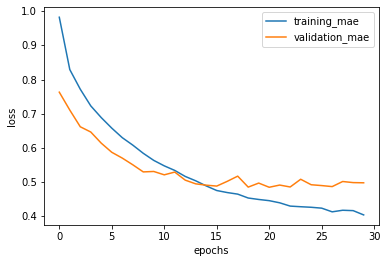

In [32]:
plot_loss(history)

In [34]:
## using the input made from tokenizer

model_100D_token =  make_model(embedding_matrix_100_token, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_100D_token.summary()

history = model_100D_token.fit(X_train_padded, y_train, batch_size=128, epochs=30, validation_data=(X_dev_padded, y_dev), callbacks=callback)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         2433700   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 128)         84480     
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

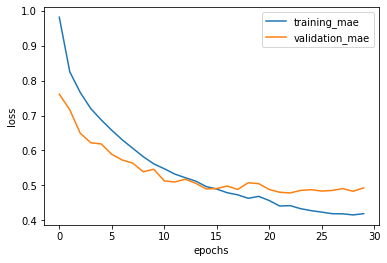

In [35]:
plot_loss(history)

#### 200D Word Embeddings 

In [36]:
embeddings_200 = import_embeddings('/content/glove.6B.200d.txt')
embedding_matrix_200 = make_embedding_matrix(word_index, 200, embeddings_200)

## makes embedding matrix with token vectors
embedding_matrix_200_token = make_embedding_matrix(word_index_token,200, embeddings_200)

Found 400000 word vectors.
Converted 13237 words (6763 misses)
Converted 18169 words (6166 misses)


In [39]:
model_200D_vector = make_model(embedding_matrix_200, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_200D_vector.summary()

history = model_200D_vector.fit(X_train_vector, y_train, batch_size=128, epochs=30, validation_data=(X_dev_vector, y_dev), callbacks=callback)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 200)         4000400   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, None, 128)         135680    
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_25 (Dense)             (None, 1)               

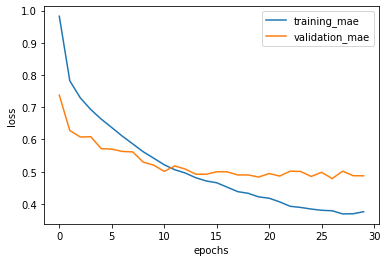

In [40]:
plot_loss(history)

In [ ]:
model_200D_token =  make_model(embedding_matrix_200_token, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_200D_token.summary()

history = model_200D_token.fit(X_train_padded, y_train, batch_size=128, epochs=30, validation_data=(X_dev_padded, y_dev), callbacks=callback)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 200)         4867400   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, None, 128)         135680    
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_27 (Dense)             (None, 1)               

### Embeddings 300D

In [36]:
embeddings_300 = import_embeddings('/content/glove.6B.300d.txt')
embedding_matrix_300 = make_embedding_matrix(word_index, 300, embeddings_300)

embedding_matrix_300_token = make_embedding_matrix(word_index_token,300, embeddings_300)

Found 400000 word vectors.
Converted 13237 words (6763 misses)


In [ ]:
model_300D_vector = make_model(embedding_matrix_300, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_300D_vector.summary()

history = model_model_300_vector.fit(X_train_vector, y_train, batch_size=128, epochs=30, validation_data=(X_dev_vector, y_dev), callbacks=callback)

In [ ]:
model_300D_token =  make_model(embedding_matrix_300_token, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_300D_token.summary()
history = model_300D_token.fit(X_train_padded, y_train, batch_size=128, epochs=30, validation_data=(X_dev_padded, y_dev), callbacks=callback)

In [ ]:
!zip -r /content/callback.zip /content/callbacks